# Setup

In [ ]:
# !pip install statsmodels
# !pip install pmdarima
# !pip install matplotlib
# !pip install seaborn
# # !pip install "black[jupyter]"
# !pip3 install statsforecast
# # !pip install prophet
# !pip install --upgrade plotly
# !pip install learntools


In [1]:
# basic
import sys
from datetime import date
import pandas as pd
import numpy as np
from numpy import inf
import time 
from datetime import datetime

# plotting
from matplotlib import pyplot, dates
import seaborn as sns
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Smoothing & Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# ARIMA
import statsmodels.api as sm
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols
from statsmodels.tsa.ar_model import AR, ARResults, AutoReg, ar_select_order
from statsmodels.tsa.arima_model import ARMA, ARMAResults, ARIMAResults
from statsmodels.tsa.arima.model import  ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

# prophet
import prophet

# forecast
from statsforecast import StatsForecast

# eval
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import mse, rmse, meanabs

# descriptive tests
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller,grangercausalitytests
from statsmodels.graphics.tsaplots import month_plot, quarter_plot, plot_acf, plot_pacf


# warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

/Users/axiao/.pyenv/versions/3.8.18/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%cd /Users/axiao/Desktop/Projects/projects/store_sales/data

holidays_events = pd.read_csv('holidays_events.csv', index_col='date', parse_dates=True)
transactions = pd.read_csv('transactions.csv',index_col='date', parse_dates=True)
oil =  pd.read_csv('oil.csv',index_col='date', parse_dates=True)
stores = pd.read_csv('stores.csv')

# train = pd.read_csv('train.csv', index_col='date', parse_dates=True)
train_engineered = pd.read_csv('train_engineered.csv', index_col='date', parse_dates=True)  # for re-run purposes
test = pd.read_csv('test.csv', index_col='date', parse_dates=True)

/Users/axiao/Desktop/Projects/projects/store_sales/data


# `holidays_events`

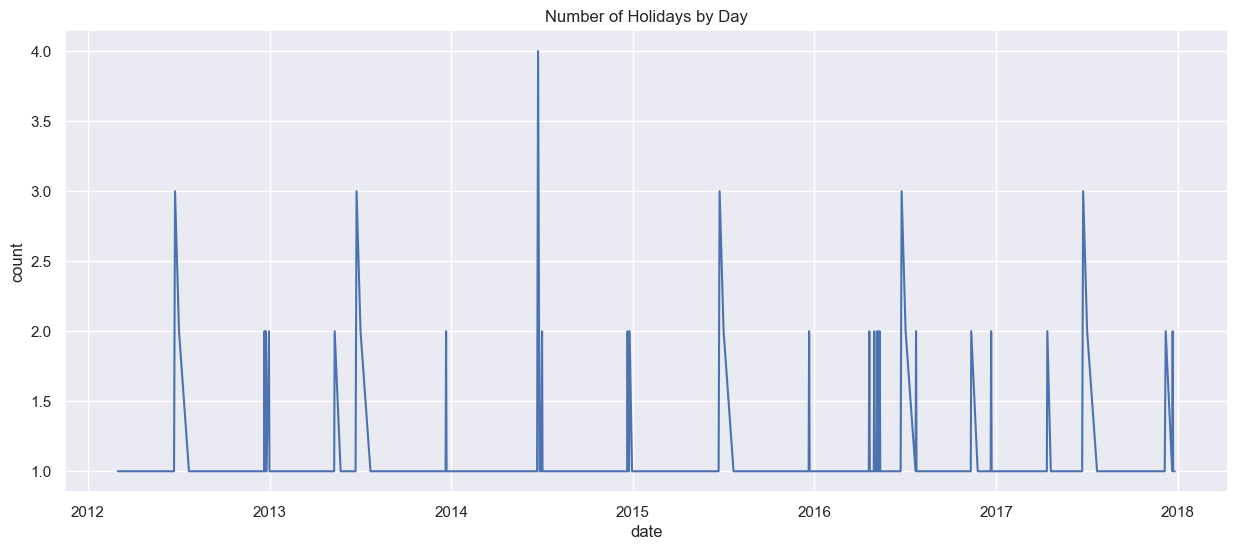

In [8]:
tmp = holidays_events.reset_index()[['date','description']].groupby('date').count().rename(columns={'description':'count'})

# plot
sns.set_theme()
sns.set(rc={'figure.figsize':(15,6)})
sns.lineplot(
    x='date', y='count',
    data=tmp
).set(title='Number of Holidays by Day');

We observe that there have been different number of holidays around middle of the year

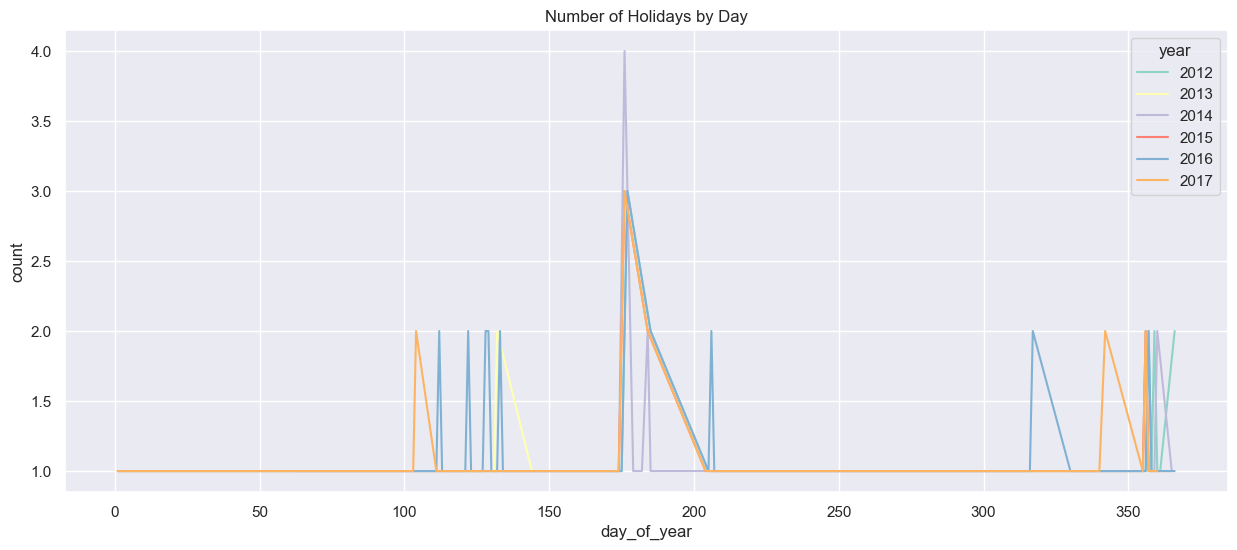

In [21]:
tmp = holidays_events.reset_index()[['day_of_year','year', 'description']].groupby(['day_of_year','year']).count().rename(columns={'description':'count'}).reset_index()

sns.set(rc={'figure.figsize':(15,6)})

sns.lineplot(
    x='day_of_year', 
    y='count',
    hue='year',
    data=tmp,
    palette='Set3'
).set(title='Number of Holidays by Day');

# pyplot.xticks(range(0,len(tmp),25));


around June 25

In [23]:
tmp = holidays_events.reset_index()[['day_of_year','year', 'description']].groupby(['day_of_year','year']).count().rename(columns={'description':'count'}).reset_index()
tmp.sort_values(by=['count'],ascending=False)

,day_of_year,year,count
118,176,2014,4
122,177,2016,3
121,177,2012,3
120,176,2017,3
117,176,2013,3
...,...,...,...
103,144,2015,1
102,144,2014,1
101,144,2013,1
100,137,2016,1


Seems to be a result of `mundial de futbol brasil`

In [28]:
holidays_events[
    ((holidays_events.day_of_year==176) | (holidays_events.day_of_year==177))
    & (holidays_events.year==2014)
]

,type,locale,locale_name,description,transferred,day_of_year,year
date,,,,,,,
2014-06-25,Holiday,Local,Latacunga,Cantonizacion de Latacunga,False,176,2014
2014-06-25,Holiday,Local,Machala,Fundacion de Machala,False,176,2014
2014-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False,176,2014
2014-06-25,Event,National,Ecuador,Mundial de futbol Brasil: Ecuador-Francia,False,176,2014


Deconstructing holidays & events to a daily basis. 

We can see how holidays and events on different locale and type levels mount to 4 holidays in a day (e.g. 2 local holidays, 1 regional, and 1 national). 

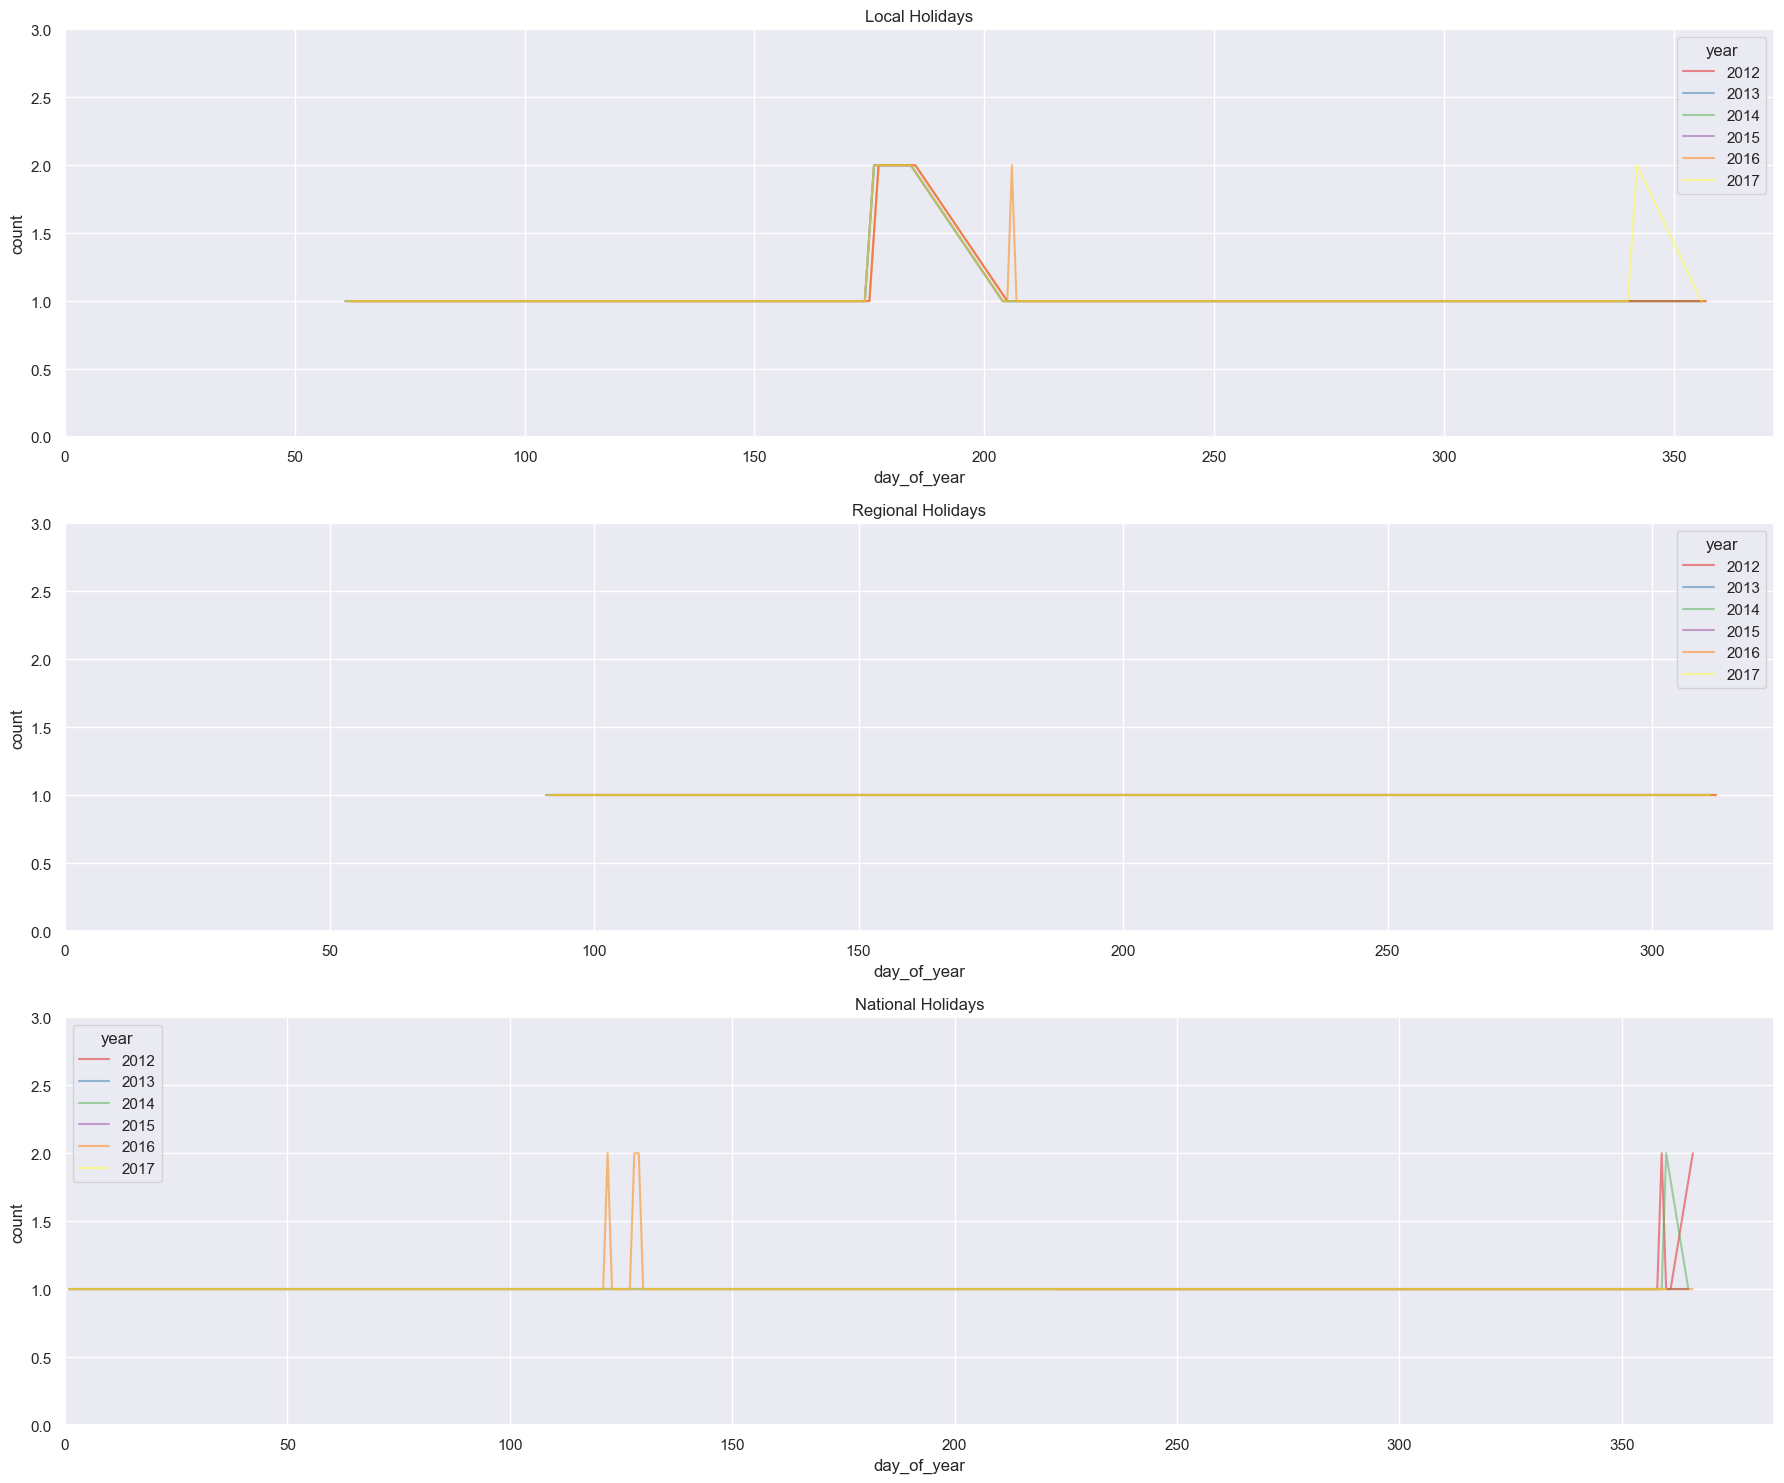

In [21]:
tmp = holidays_events.reset_index()[['year','day_of_year','locale', 'description']].groupby(['year','day_of_year','locale']).count().rename(columns={'description':'count'}).reset_index()

sns.set_theme()
fig, ax = pyplot.subplots(3,1, figsize=(18,15))

for i, locale in enumerate(tmp.locale.unique().tolist()):
    sns.lineplot(
        x='day_of_year',
        y='count',
        data=tmp[tmp['locale']==locale],
        hue='year',
        alpha=.5,
        palette='Set1',
        ax=ax[i]
    )
    ax[i].set_title(f'{locale} Holidays')
    ax[i].set_xlim(0)
    ax[i].set_ylim([0,3])

pyplot.tight_layout();

63% of the entires are `holidays`

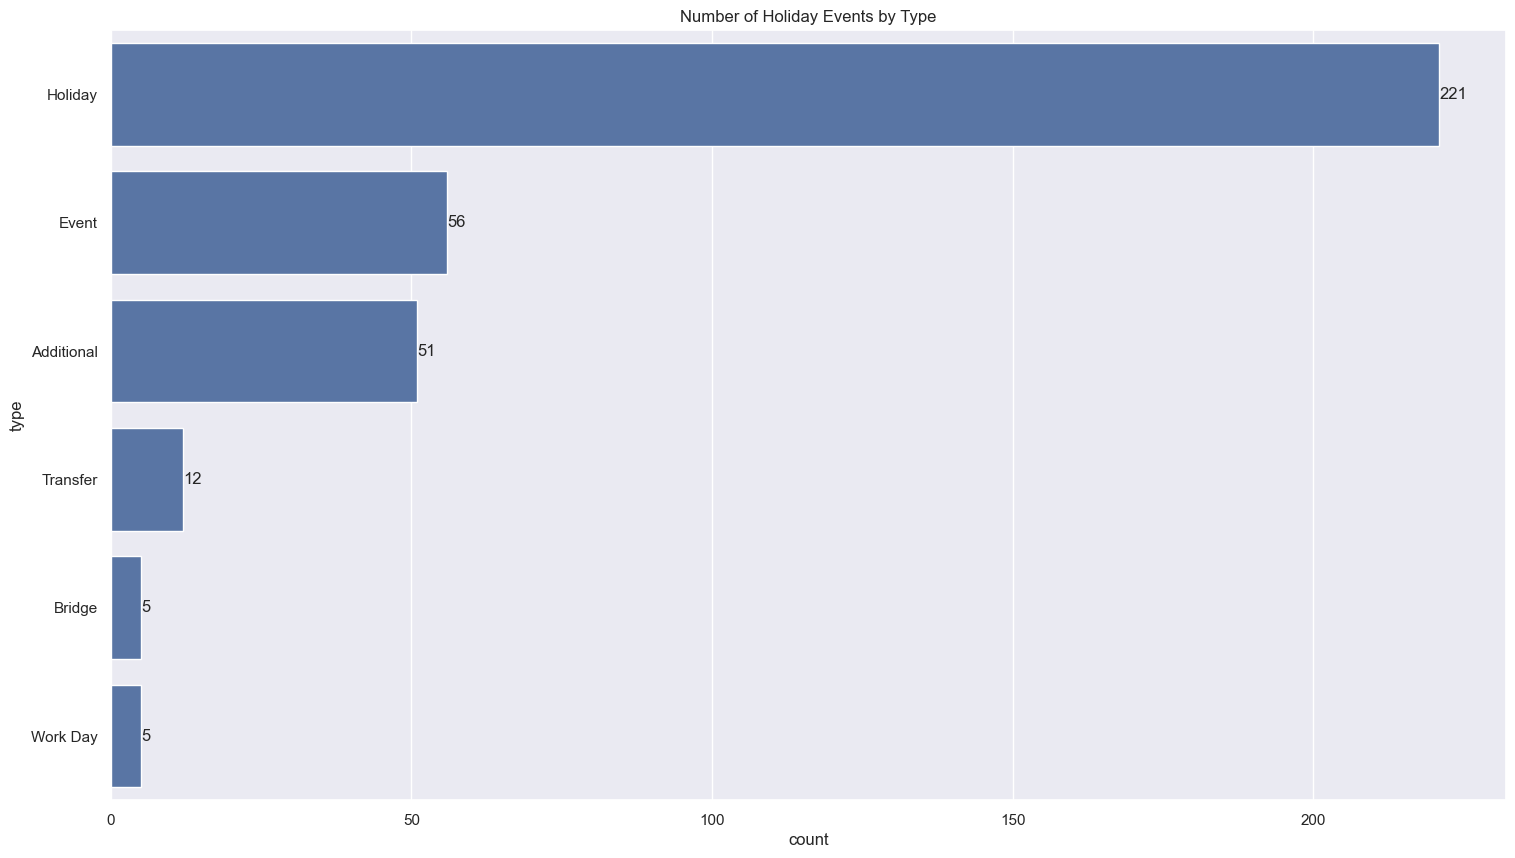

In [41]:
sns.set_theme()

sns.set(rc={'figure.figsize':(18,10)})

ax = sns.countplot(
    y='type',
    data=holidays_events,
    order=holidays_events['type'].value_counts().index
)
ax.set(title='Number of Holiday Events by Type')
ax.bar_label(ax.containers[0]);

174 (49%) of the entries are National

[Text(0, 0, '174'), Text(0, 0, '152'), Text(0, 0, '24')]

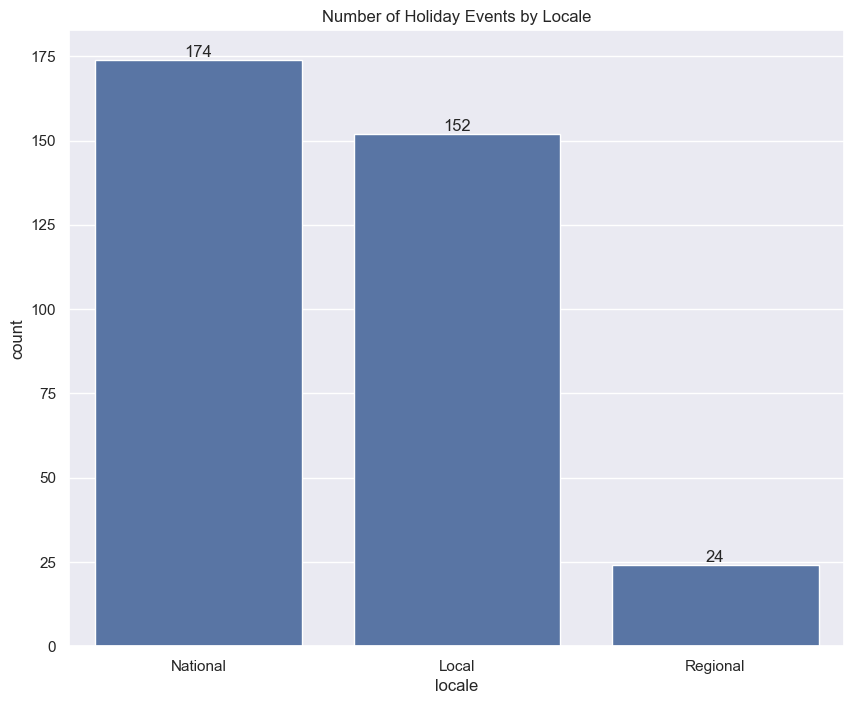

In [25]:
sns.set_theme()
sns.set(rc={'figure.figsize':(10,8)})

ax = sns.countplot(
    x='locale',
    data=holidays_events,
    order=holidays_events['locale'].value_counts().index
)
ax.set(title='Number of Holiday Events by Locale')
ax.bar_label(ax.containers[0])

174 (49%)of the entries are related to Ecuador

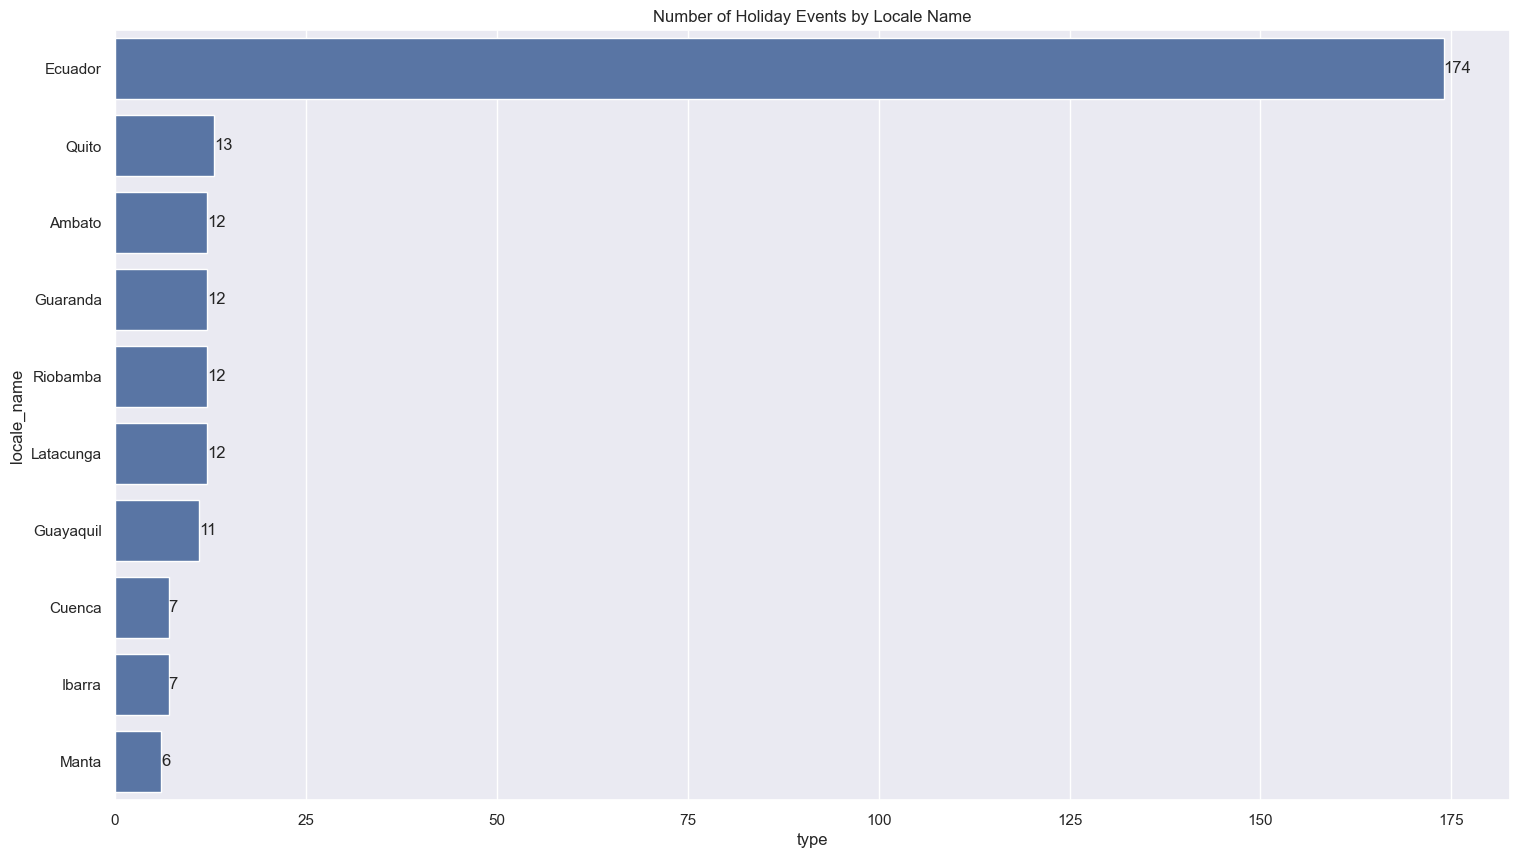

In [42]:
sns.set_theme()
sns.set(rc={'figure.figsize':(18,10)})

top10_locale_names = holidays_events[['locale_name','type']].groupby(['locale_name']).count().sort_values(by=['type'], ascending=[False]).reset_index()[:10]

ax = sns.barplot(
    top10_locale_names, 
    x='type', 
    y='locale_name')
ax.set(title='Number of Holiday Events by Locale Name')
ax.bar_label(ax.containers[0]);

Carnaval is the most holiday/event with the most days off (10).

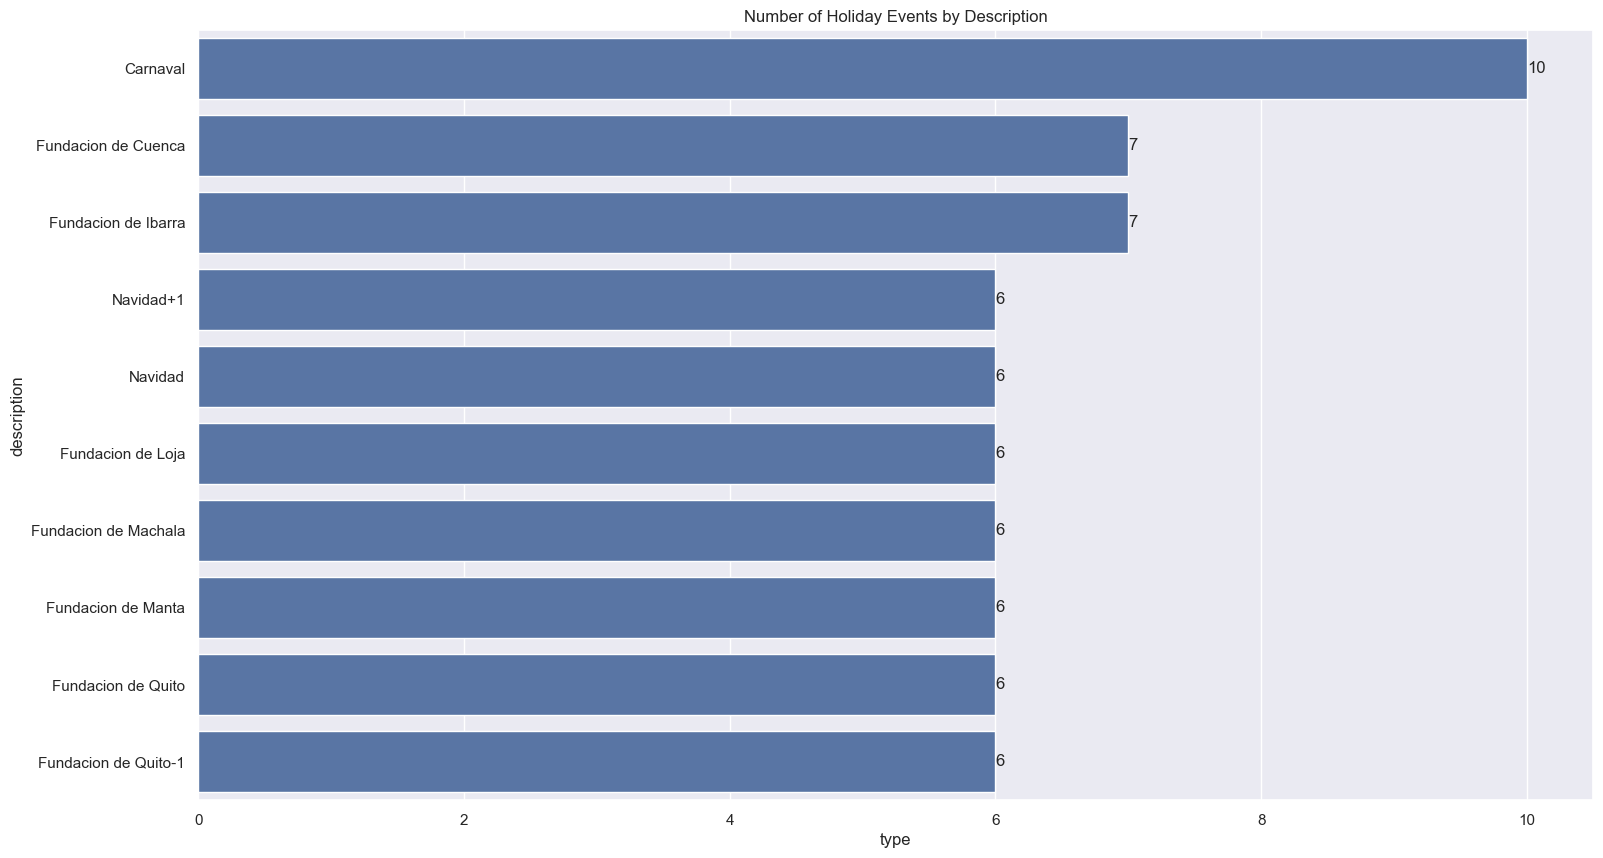

In [43]:
sns.set_theme()
top10_descriptions_names = holidays_events[['description','type']].groupby(['description']).count().sort_values(by=['type'], ascending=[False]).reset_index()[:10]

ax = sns.barplot(top10_descriptions_names, x='type', y='description')
ax.set(title='Number of Holiday Events by Description')
ax.bar_label(ax.containers[0]);

# `transactions`

Daily transaction amount follows similar patterns throughout the year. However, the total amount of transactions grew year over year (i.e. generally speaking, on the same day of the year, 2017 had the higher number of transactions than those of 2013-2016).

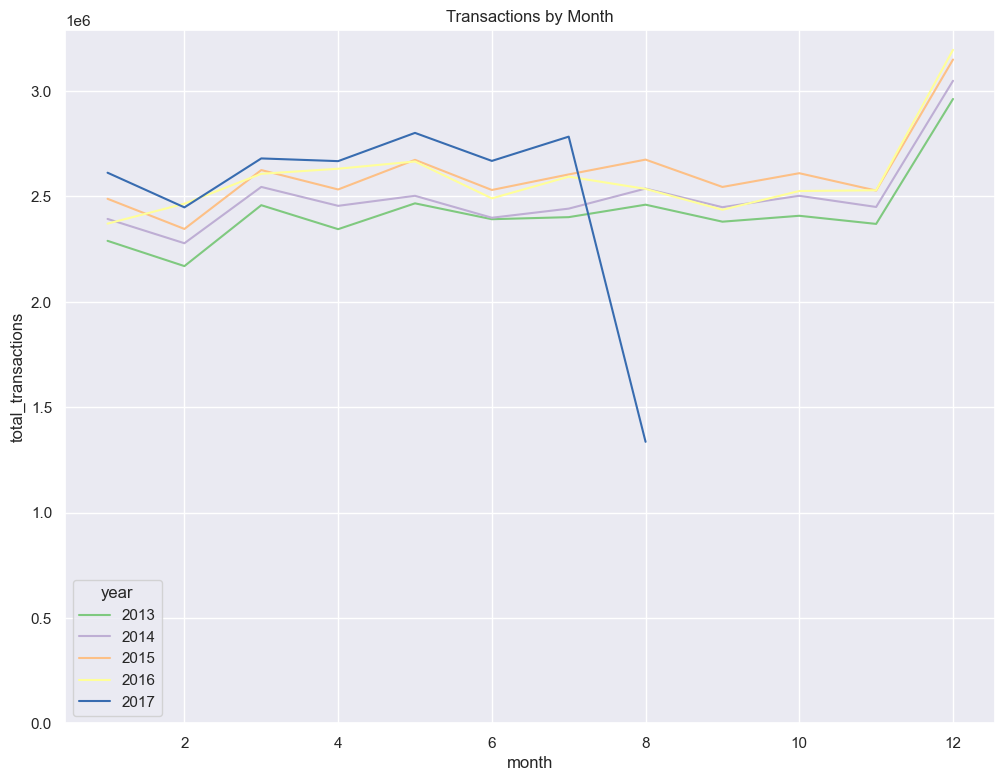

In [45]:
tmp = transactions.reset_index()[['month','year', 'transactions']].groupby(['month','year']).sum().rename(columns={'transactions':'total_transactions'}).reset_index()

sns.set(rc={'figure.figsize':(12,9)})
ax = sns.lineplot(
    x='month', 
    y='total_transactions',
    hue='year',
    data=tmp,
    palette='Accent',
    # alpha=.5
)
ax.set(title='Transactions by Month')
ax.set(ylim=(0, None));

On a monthly level, the highest number of transactions occur in December, while February the lowest.

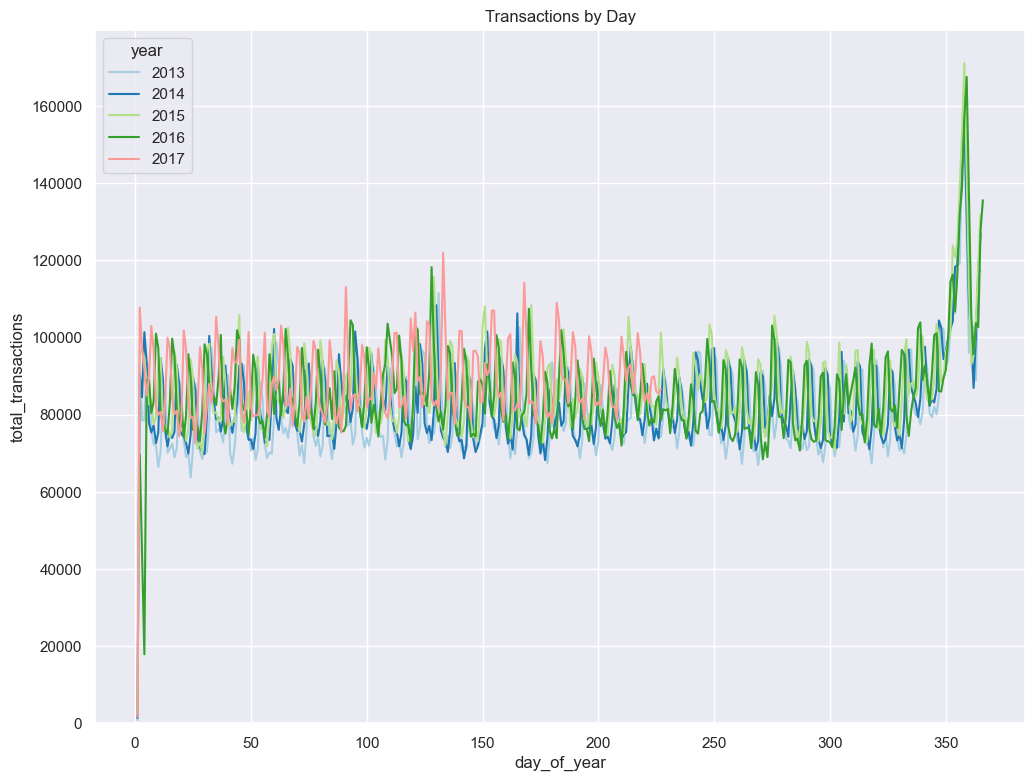

In [44]:
tmp = transactions.reset_index()[['day_of_year','year', 'transactions']].groupby(['day_of_year','year']).sum().rename(columns={'transactions':'total_transactions'}).reset_index()

sns.set(rc={'figure.figsize':(12,9)})
ax = sns.lineplot(
    x='day_of_year', 
    y='total_transactions',
    hue='year',
    data=tmp,
    palette='Paired',
    # alpha=.5
)
ax.set(title='Transactions by Day')
ax.set(ylim=(0, None));

Saturdays have the highest average sales of a week and Thursdays the lowest.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


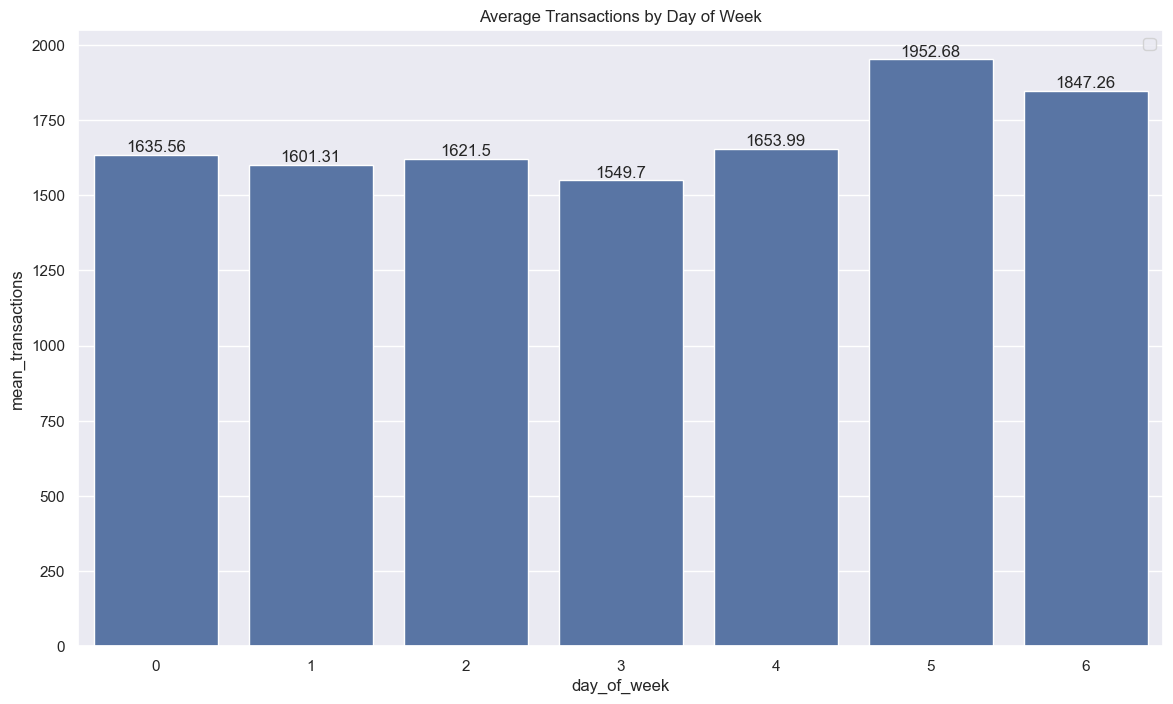

In [43]:
tmp = transactions.copy()
tmp['day_of_week'] = transactions.index.dayofweek
tmp = tmp.reset_index()[['day_of_week', 'transactions']].groupby(['day_of_week']).mean().rename(columns={'transactions':'mean_transactions'}).reset_index()


sns.set(rc={'figure.figsize':(14,8)})
ax = sns.barplot(
    x='day_of_week', 
    y='mean_transactions',
    # hue='year',
    data=tmp,
    # palette='Accent',
    # alpha=.5
)
ax.legend(loc='upper right')
ax.set(title='Average Transactions by Day of Week')
ax.set(ylim=(0, None))
ax.bar_label(ax.containers[0]);

Total numbers of transactions by store. The 5 best selling stores are No. 44, 47, 45, 46, and 3.

[Text(0.5, 1.0, 'Total Transactions by Store Number')]

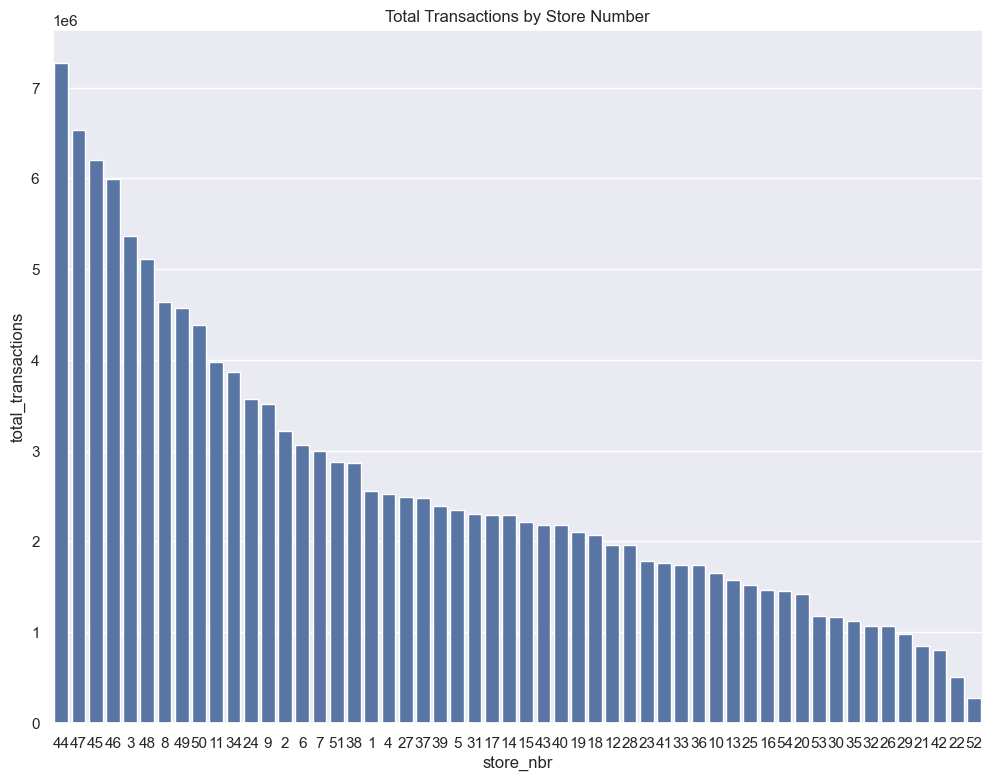

In [46]:
tmp = transactions.reset_index()\
    [['store_nbr', 'transactions']].\
        groupby(['store_nbr']).sum().\
            rename(columns={'transactions':'total_transactions'}).\
                sort_values(by=['total_transactions'], ascending=[False]).\
                    reset_index()
tmp.sort_values(by=['total_transactions'],ascending=[False])[:10]

ax = sns.barplot(
    data=tmp,
    x='store_nbr',
    y='total_transactions', 
    order=tmp['store_nbr'],
    # palette='Accent',
    # alpha=.5
)
# ax.bar_label(ax.containers[0])
ax.set(title='Total Transactions by Store Number')
# ax.set(ylim=(0, None));

# `oil`

Plot interpolated oil price. Oil price had gone lower since 2013.

[Text(0.5, 1.0, 'Oil Price (Interpolated) Over Time')]

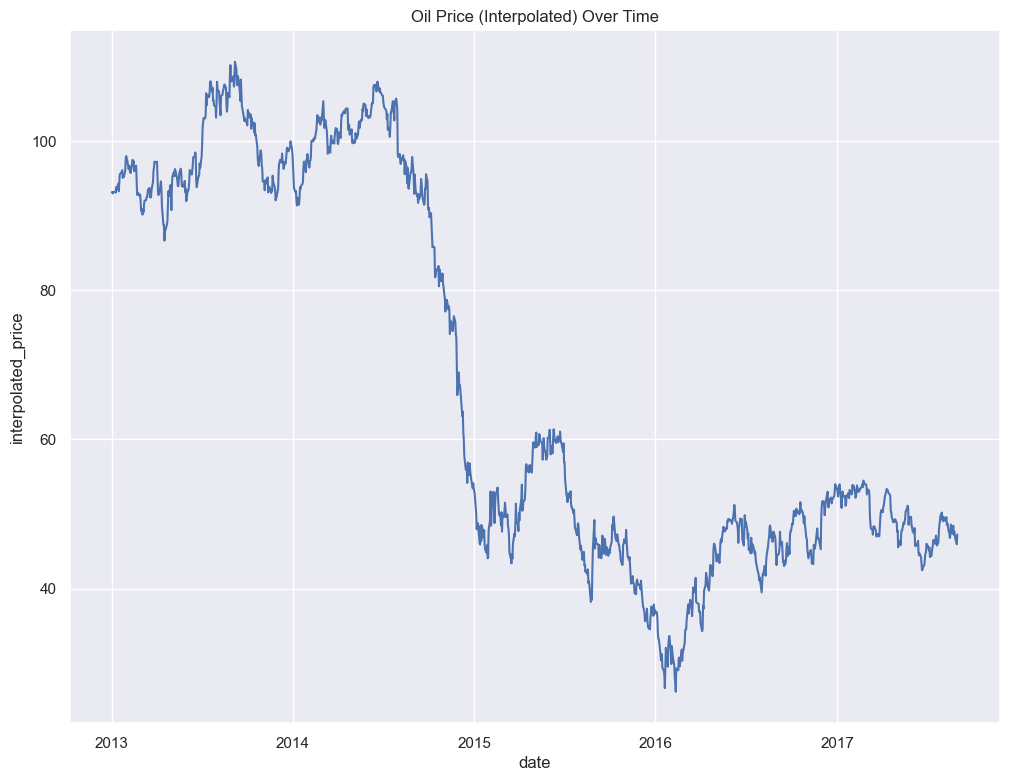

In [47]:
sns.set_theme()
sns.lineplot(
    x='date', y='interpolated_price',
    data=oil.reset_index()
).set(title='Oil Price (Interpolated) Over Time')

Tthere seems to be a negative correlation between daily oil price and total sales.

[Text(0.5, 1.0, 'Regression Plot\nDaily Oil Price & Total Sales')]

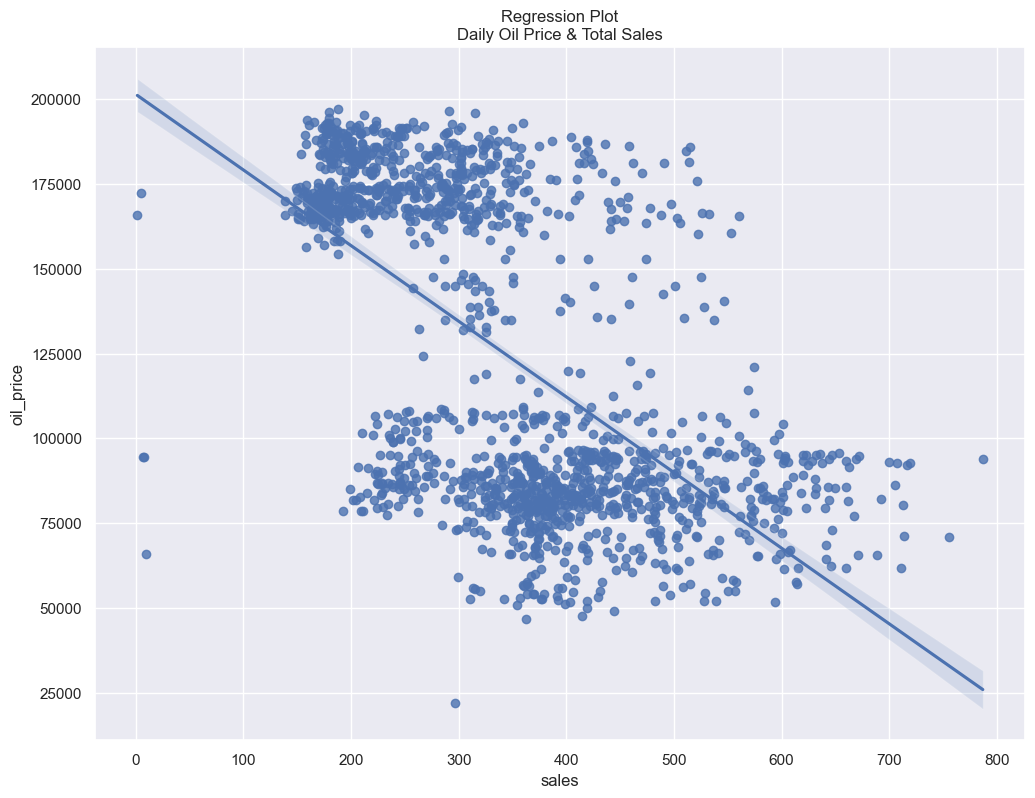

In [49]:
tmp = train_engineered.reset_index()[['date', 'sales', 'oil_price']]
tmp1 = tmp.groupby(['date']).agg({'sales': 'mean', 'oil_price': 'sum'})
tmp1['year'] = tmp1.reset_index().date.dt.year.astype("int32").tolist()

# log
# tmp1['sales'] = np.log10(tmp1['sales'])
# tmp1['oil_price'] = np.log10(tmp1['oil_price'])

sns.set_theme()
sns.regplot(
    data=tmp1,
    x='sales',
    y='oil_price',
    # hue='year',
    # palette='GnBu'
).set(title=f'Regression Plot\nDaily Oil Price & Total Sales')

This explains why sales records were higher in, for example, 2017 than 2013.

[Text(0.5, 1.0, 'Scatter Plot\nDaily Oil Price & Total Sales')]

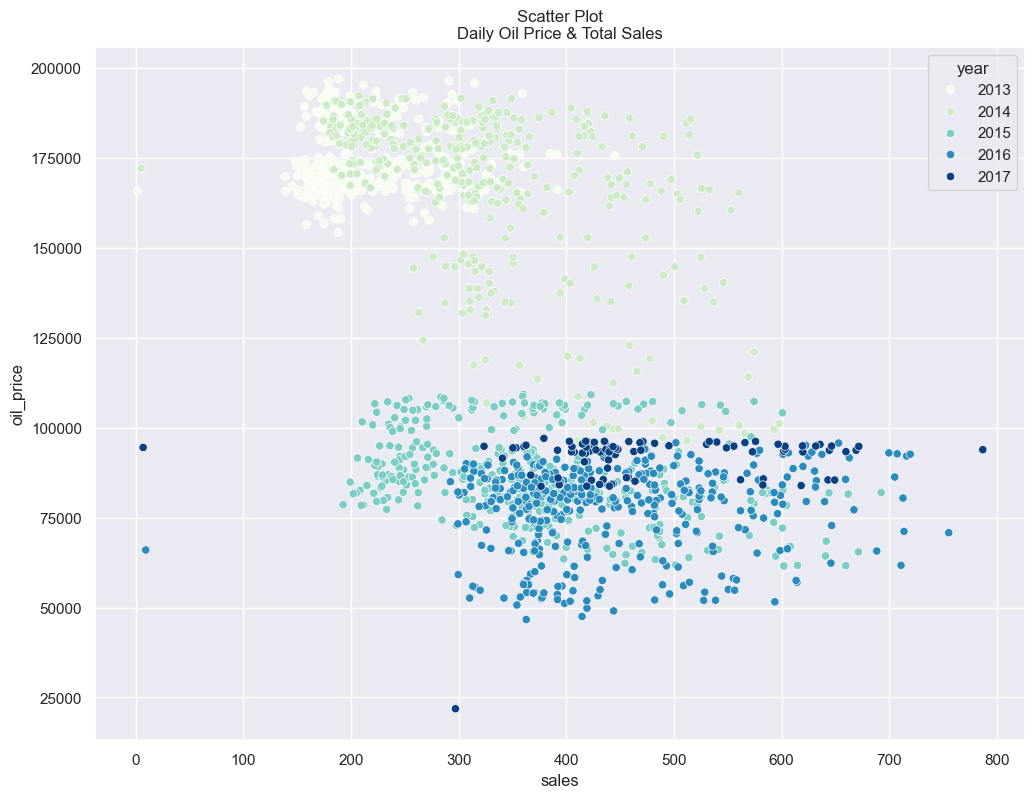

In [50]:
tmp = train_engineered.reset_index()[['date', 'sales', 'oil_price']]
tmp1 = tmp.groupby(['date']).agg({'sales': 'mean', 'oil_price': 'sum'})
tmp1['year'] = tmp1.reset_index().date.dt.year.astype("int32").tolist()

sns.set_theme()
sns.scatterplot(
    data=tmp1,
    x='sales',
    y='oil_price',
    hue='year',
    palette='GnBu'
).set(title=f'Scatter Plot\nDaily Oil Price & Total Sales')

# `train`

Grocery I is the best selling product family, taking up 32% of sales of all product families. 

Grocery I along with the second best-selling product family, beverages, together make up 52% of all sales.

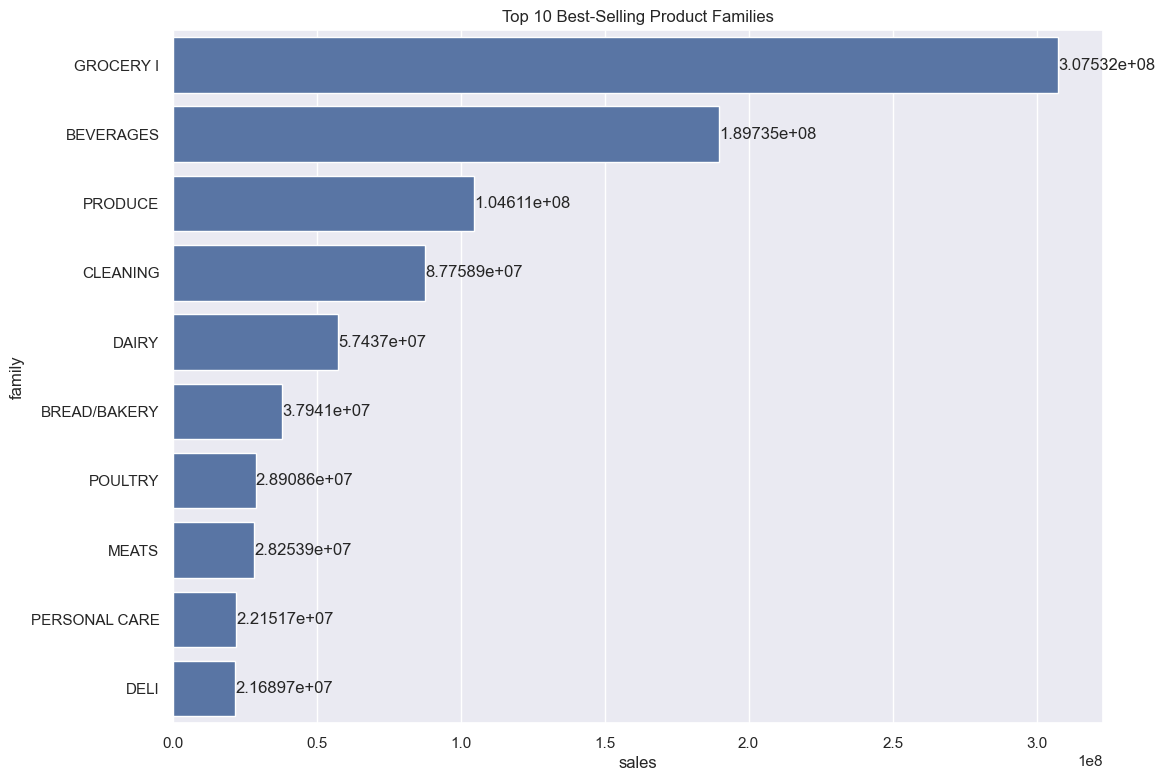

In [51]:
tmp = train_engineered.reset_index()[['family','sales']].groupby(['family']).sum('sales').reset_index().sort_values(by=['sales'], ascending=False)
best_selling_fam = tmp[:10]['family']

ax = sns.barplot(tmp[:10], y='family', x='sales')
ax.set_title('Top 10 Best-Selling Product Families')
ax.bar_label(ax.containers[0]);

Same view but in a line graph. Demands (and sales) for grocery, beverages, and product are highest in March, December, and July, whereas a sharp drop occurs in July and continues from August to November.

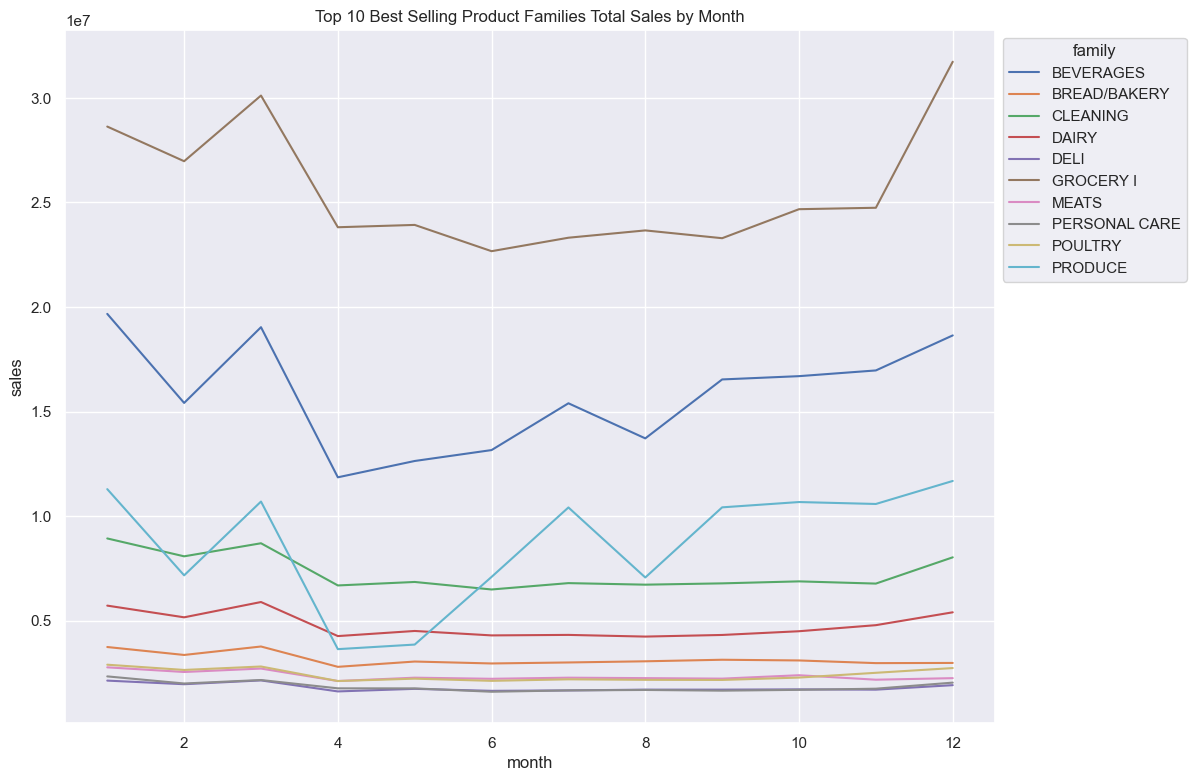

In [53]:
tmp = train_engineered.reset_index()[['family','sales']].groupby(['family']).sum('sales').reset_index().sort_values(by=['sales'], ascending=False)
best_selling_fam = tmp[:10]['family']

tmp2 = train_engineered.reset_index()[['month','family','sales']].groupby(['month', 'family']).sum('sales').reset_index()
tmp2 = tmp2[tmp2['family'].isin(best_selling_fam)]

ax=sns.lineplot(tmp2, x='month', y='sales', hue='family')
ax.set_title('Top 10 Best Selling Product Families Total Sales by Month')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

Alternative view providing similar information as above but on a more granular level (day of year).

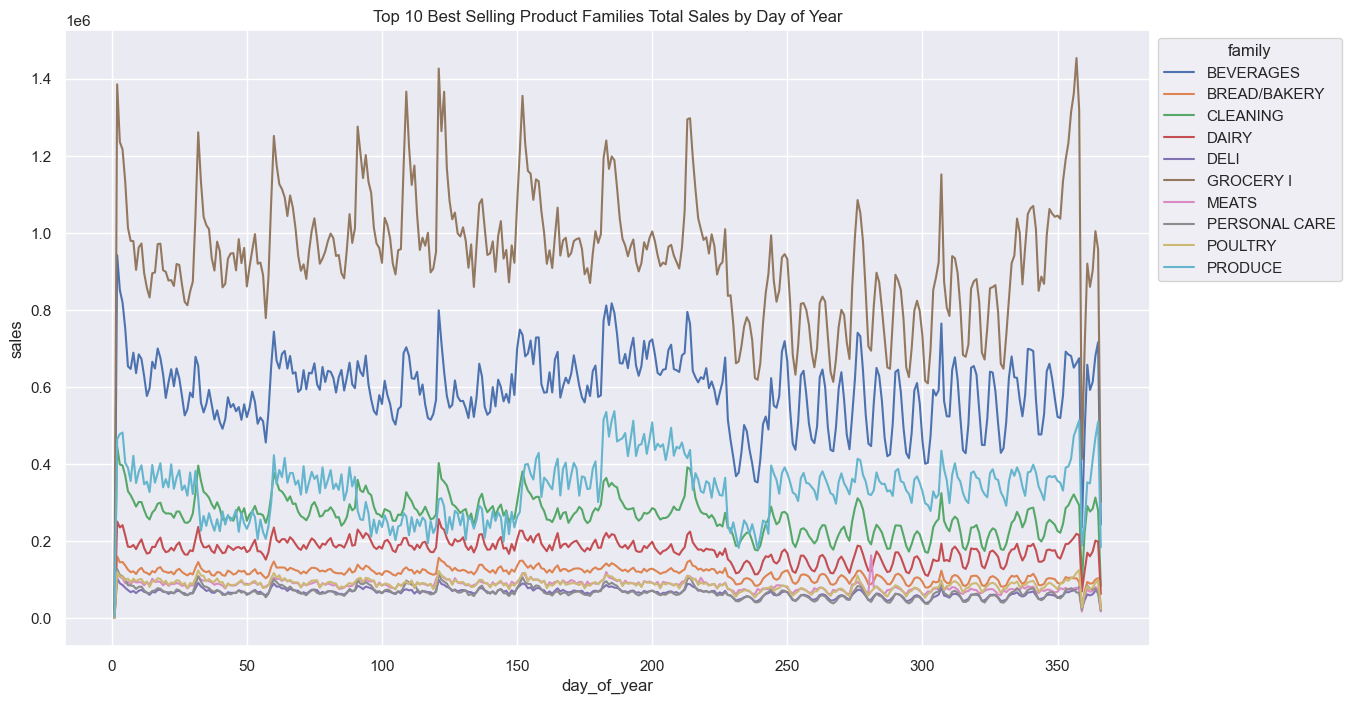

In [48]:
tmp = train_engineered.reset_index()[['family','sales']].groupby(['family']).sum('sales').reset_index().sort_values(by=['sales'], ascending=False)
best_selling_fam = tmp[:10]['family']

tmp2 = train_engineered.reset_index()[['day_of_year','family','sales']].groupby(['day_of_year', 'family']).sum('sales').reset_index()
tmp2 = tmp2[tmp2['family'].isin(best_selling_fam)]

ax=sns.lineplot(tmp2, x='day_of_year', y='sales', hue='family')
ax.set_title('Top 10 Best Selling Product Families Total Sales by Day of Year')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

Average sales are the highest in Dec., followed by July, March, and Jan.

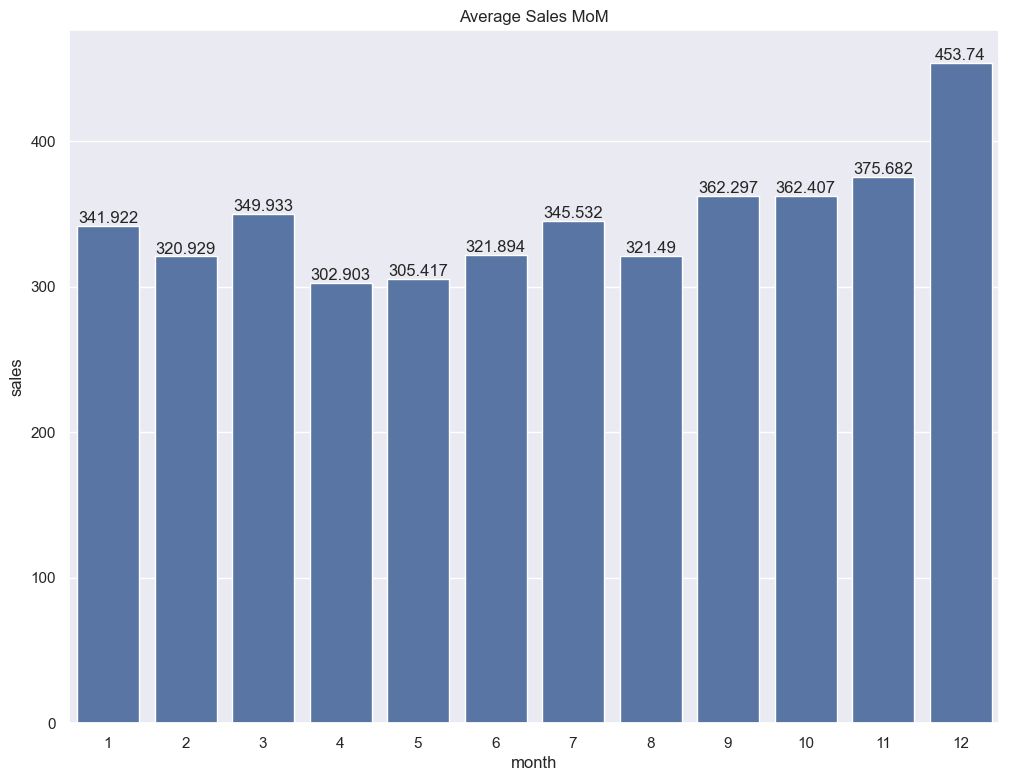

In [56]:
tmp =train_engineered[['sales', 'month']].groupby('month').mean().reset_index()


ax = sns.barplot(tmp, x='month', y='sales', )
# ax.set(ylabel=None)
ax.set_title('Average Sales MoM')
ax.bar_label(ax.containers[0]);

Comparison of average monthly sales from 2013 to 2017. 

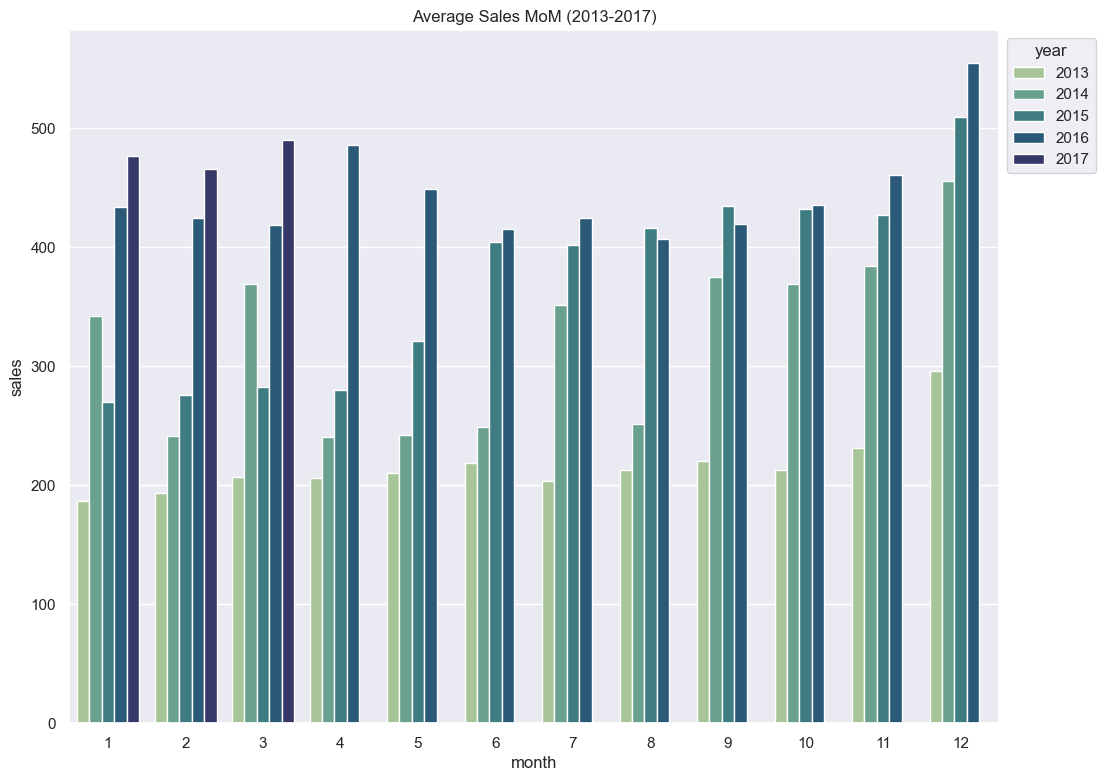

In [58]:
tmp =train_engineered[['sales', 'month','year']].groupby(['year', 'month']).mean().reset_index()

sns.set_theme()
ax = sns.barplot(data=tmp, x='month', y='sales', hue='year', palette='crest')
# ax = tmp.plot.bar(x='month', y='sales', color=cm.get_cmap('Spectral') )
# ax.set(ylabel=None)
ax.set_title('Average Sales MoM (2013-2017)')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1));
# ax.bar_label(ax.containers[0]);

Same 'average sales by year' view but in a line graph. Demands (and sales) for grocery, beverages, and product are highest in March, December, and July, whereas a sharp drop occurs in July and continues from August to November.

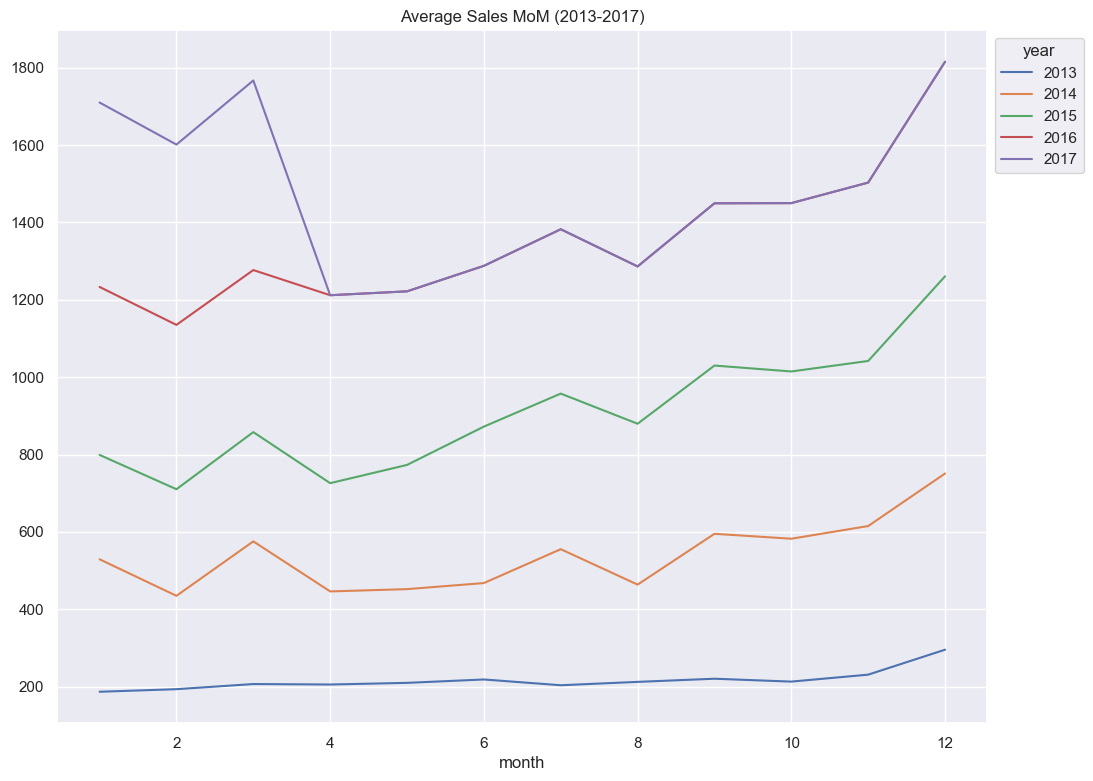

In [59]:
tmp = train_engineered[['sales', 'year', 'month']].groupby(['month','year']).mean().reset_index()
tmp = tmp.pivot(index='month', columns='year', values='sales')
# tmp['year'] = tmp['year'].astype('int')

sns.set_theme()
# tmp.T.plot(kind='bar', stacked=True,)
ax = tmp.plot(stacked=True)
ax.set_title('Average Sales MoM (2013-2017)')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1));


Same 'average sales by year' view as above - but on a more granular, daily basis.

Text(0.5, 1.0, 'Daily Average Sales')

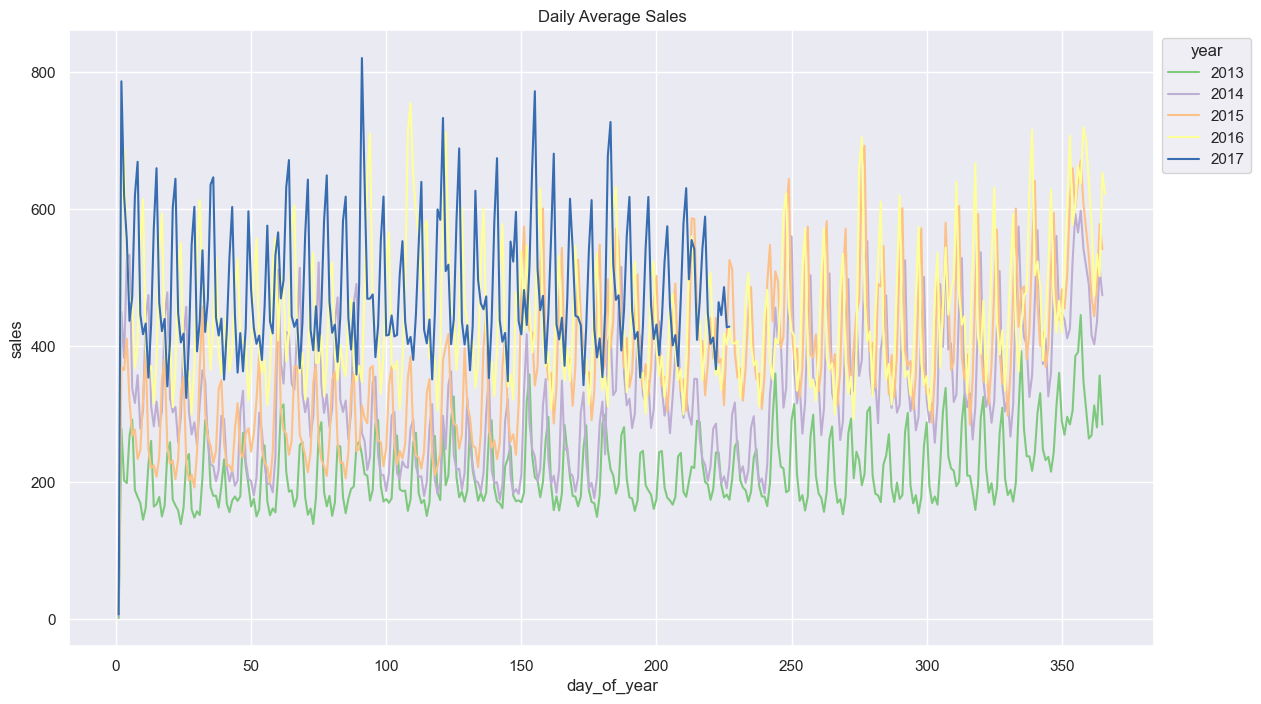

In [52]:
tmp3 = train_engineered.reset_index()[['day_of_year','sales', 'year']].groupby(['day_of_year', 'year']).mean('sales').reset_index()


ax=sns.lineplot(tmp3, x='day_of_year', y='sales', hue='year', palette='Accent')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_title('Daily Average Sales')

# `stores`

D is the most common type of stores.

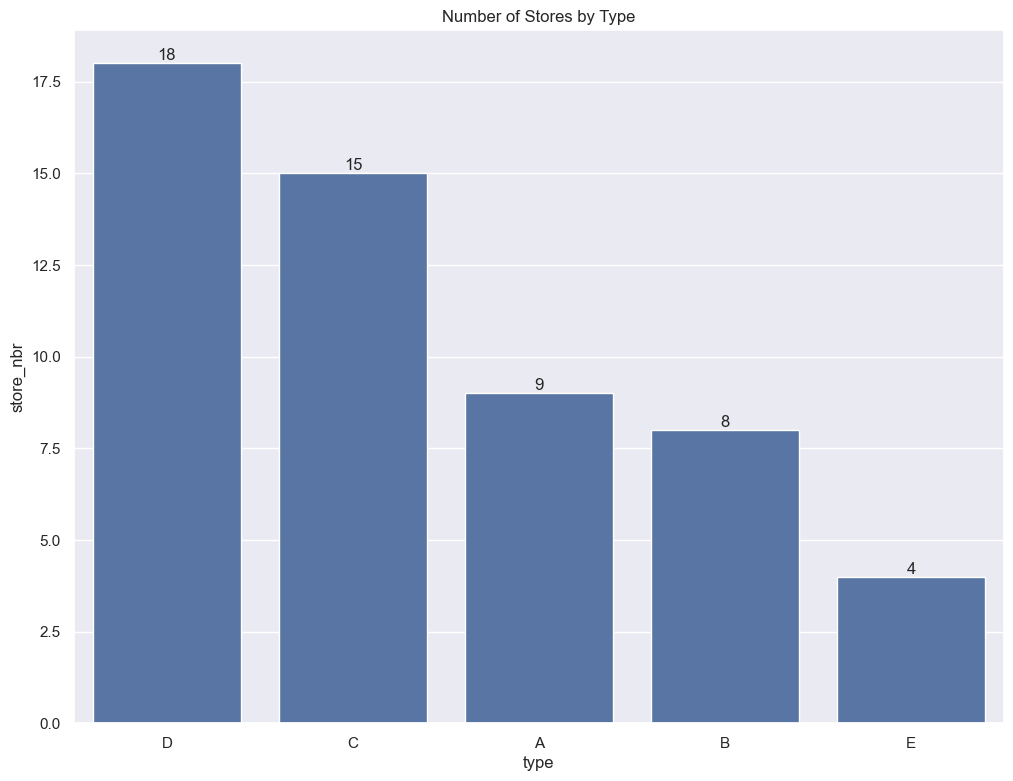

In [60]:
tmp = stores[['type', 'store_nbr']].groupby(['type']).count().reset_index().sort_values(by=['store_nbr'], ascending=[False])
ax= sns.barplot(
    x='type',
    y='store_nbr',
    order=tmp['type'],
    data=tmp
)
ax.bar_label(ax.containers[0])
ax.set(title='Number of Stores by Type');
# ax.set(ylim=(0, None));

Quito is the city with the most stores (18), taking up 33% of all stores in the country.

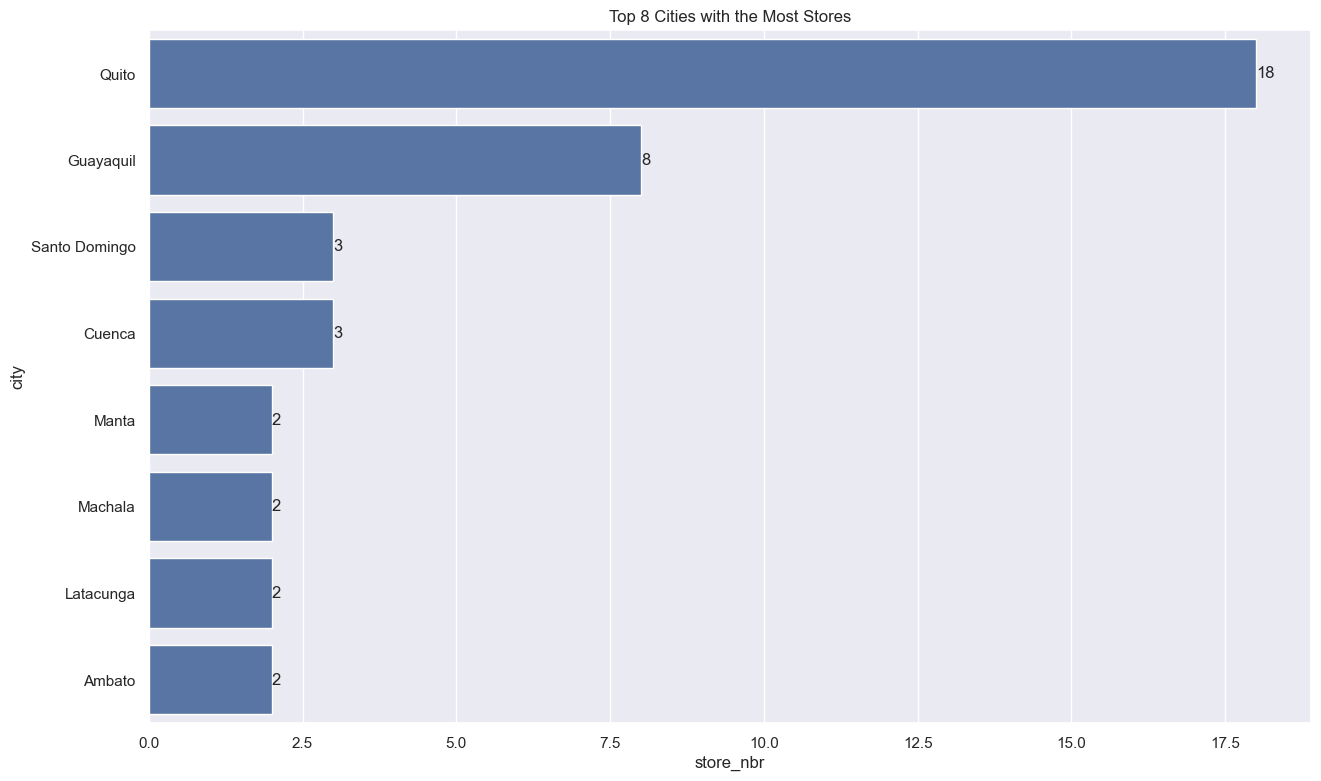

In [64]:
tmp = stores[['city', 'store_nbr']].groupby(['city']).count().reset_index().sort_values(by=['store_nbr'], ascending=[False])
tmp = tmp[:8]

sns.set_theme()
sns.set(rc={'figure.figsize':(15,9)})

ax= sns.barplot(
    y='city',
    x='store_nbr',
    order=tmp['city'],
    data=tmp
)
ax.bar_label(ax.containers[0])
ax.set(title='Top 8 Cities with the Most Stores');
# ax.set(ylim=(0, None));

Store type A has the highest sales on average.

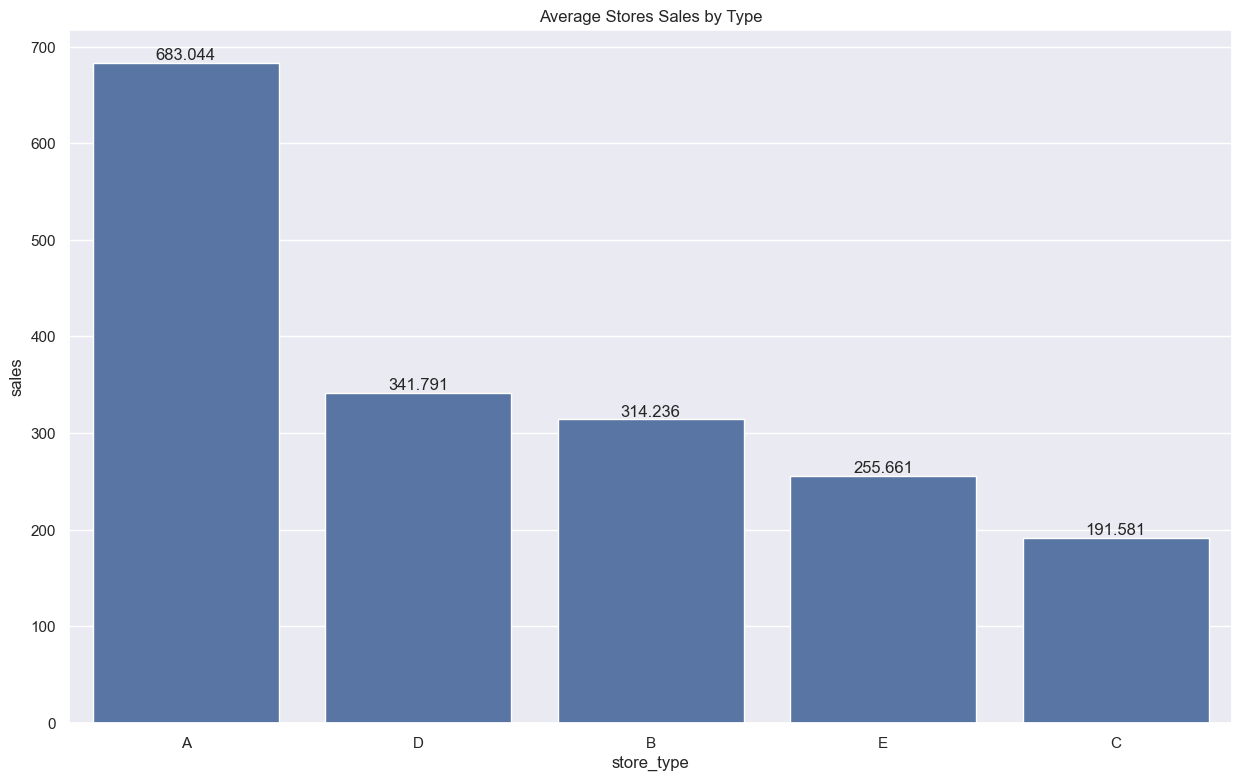

In [65]:
tmp = train_engineered.reset_index()[['sales','store_nbr','city', 'state','store_type', 'store_cluster']]
tmp1 = tmp[['sales', 'store_type']].groupby(['store_type']).mean().reset_index().sort_values(by=['sales'], ascending=False)

ax= sns.barplot(
    x='store_type',
    y='sales',
    order=tmp1['store_type'],
    data=tmp1
)
ax.bar_label(ax.containers[0])
ax.set(title='Average Stores Sales by Type');
# ax.set(ylim=(0, None));

Cluster 5 has the highest average sales. 

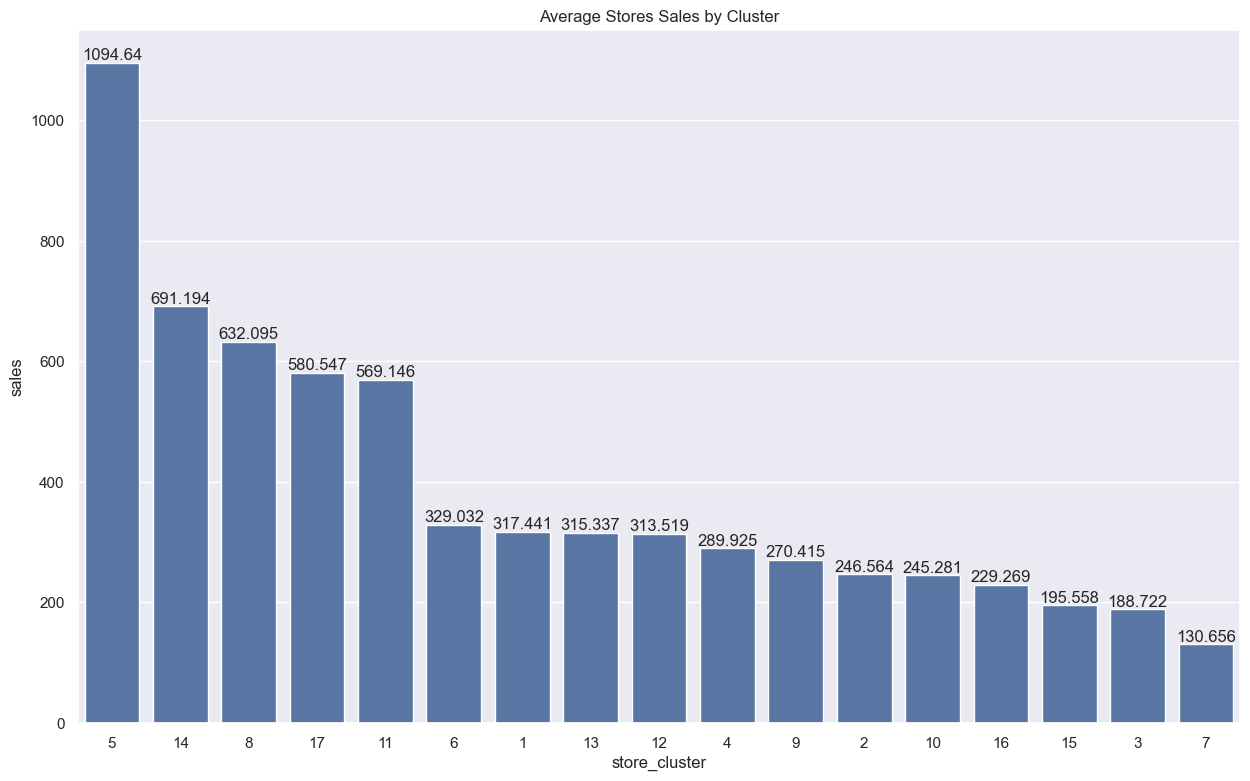

In [66]:
tmp = train_engineered.reset_index()[['sales','store_nbr','city', 'state','store_type', 'store_cluster']]
tmp1 = tmp[['sales', 'store_cluster']].groupby(['store_cluster']).mean().reset_index().sort_values(by=['sales'], ascending=False)

ax= sns.barplot(
    x='store_cluster',
    y='sales',
    order=tmp1['store_cluster'],
    data=tmp1
)
ax.bar_label(ax.containers[0])
ax.set(title='Average Stores Sales by Cluster');
# ax.set(ylim=(0, None));

# Spearman Correlation

In [67]:
train_engineered.columns[10:30]

Index(['oil_price', 'national_holidays', 'locale_name',
       'regional_local_holidays', 'out_of_region', 'month', 'day_of_month',
       'day_of_year', 'week_of_month', 'day_of_week', 'year', 'is_wknd',
       'quarter', 'is_month_start', 'is_month_end', 'is_year_start',
       'is_year_end', 'wageday', 'Batalla de Pichincha', 'Black Friday'],
      dtype='object')

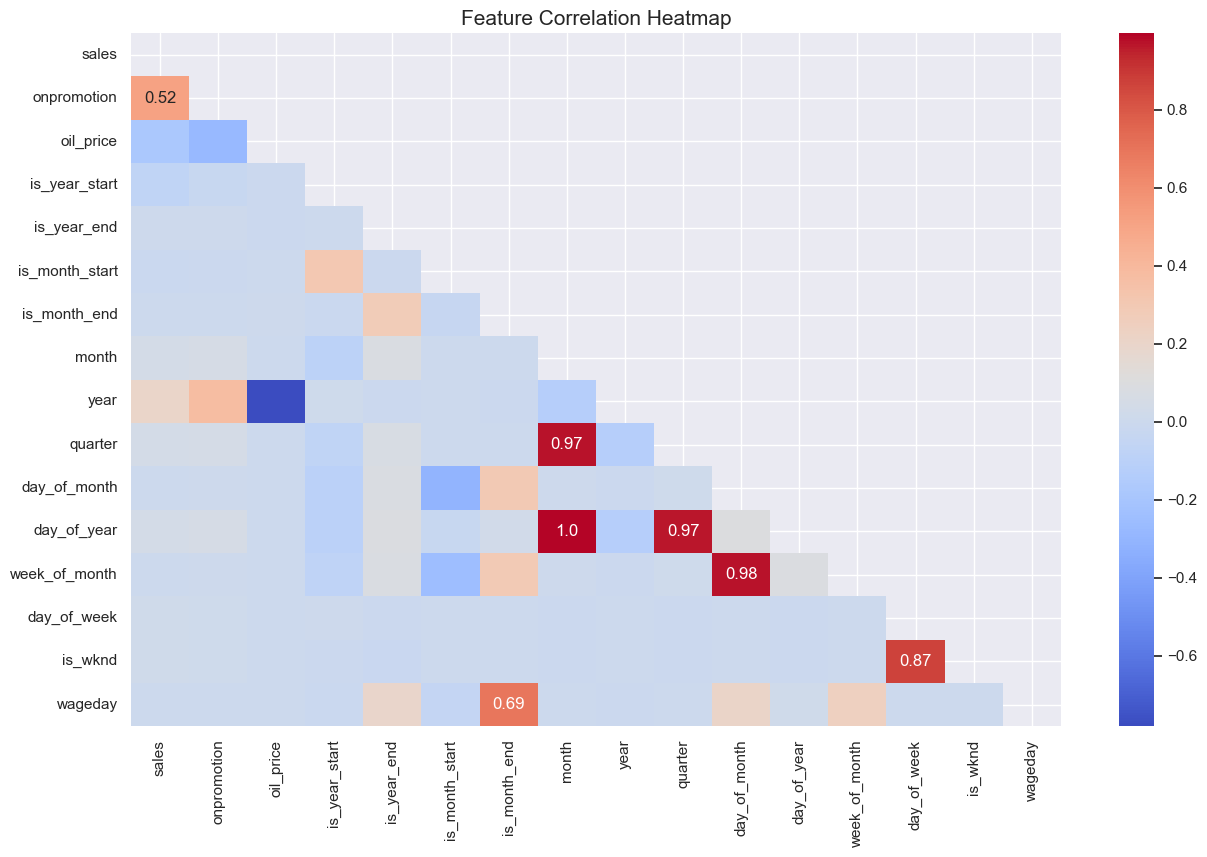

In [78]:
df = train_engineered[['sales','onpromotion','oil_price', 
    'is_year_start','is_year_end',
    'is_month_start','is_month_end',
    'month','year', 'quarter',
    'day_of_month','day_of_year',
    'week_of_month','day_of_week','is_wknd',
    'wageday']].corr(method = 'spearman')

mask = np.triu(np.ones_like(df))

# hide the insignificant values
tmp = df[df > .4]
tmp = tmp.round(2)
tmp.fillna('', inplace=True)

annot_labels = tmp.values.astype('str').tolist()


g = sns.heatmap(df, cmap='coolwarm', annot=annot_labels,fmt='', mask=mask, annot_kws={"size": 12})
pyplot.title('Feature Correlation Heatmap', fontsize=15);